[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Jouzel_and_Merlivat_1984/Si_vs_effective_Si.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Jouzel_and_Merlivat_1984/Si_vs_effective_Si.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Jouzel_and_Merlivat_1984/Si_vs_effective_Si.ipynb)

# Comparison between saturation wrt. ice and effective saturation - based on [Jouzel and Merlivat 1984](https://doi.org/10.1029/JD089iD07p11749) "_Deuterium and oxygen 18 in precipitation: Modeling of the isotopic effects during snow formation_"
eq. (13)

In [6]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [7]:
from matplotlib import pyplot
import numpy as np
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics.constants import PER_MILLE, in_unit

In [8]:
any_number = 44

In [9]:
formulae= Formulae(
    latent_heat_vapourisation="Lowe2019",
    saturation_vapour_pressure="MurphyKoop2005",
    isotope_diffusivity_ratios="Stewart1975",
    isotope_kinetic_fractionation_factors="JouzelAndMerlivat1984",
    isotope_equilibrium_fractionation_factors="MerlivatAndNief1967+Majoube1970",
    diffusion_thermics="Neglect",
)
const = formulae.constants
K2C = formulae.trivia.K2C

diffusivity_ratio = {}
alpha_eq = {}
alpha_kinetic = {}
isotopes = ("2H", "18O")
for isotope in isotopes:
    alpha_eq[isotope] = getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_i_{isotope}')
    diffusivity_ratio[isotope] = getattr(formulae.isotope_diffusivity_ratios, f'ratio_{isotope}_heavy_to_light')

In [10]:
isotope_considered = '2H'
temperature = np.linspace(225, 300, 10) * si.K

relative_humidity = 1/formulae.saturation_vapour_pressure.pvs_water(temperature)
saturation_wrt_ice = (
        formulae.saturation_vapour_pressure.pvs_water(temperature)
        / formulae.saturation_vapour_pressure.pvs_ice(temperature)
)

D_ratio = diffusivity_ratio[isotope_considered](temperature)
alpha_equilibrium = alpha_eq[isotope_considered](temperature)
alpha_kinetic = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium = alpha_equilibrium,
        D_ratio_heavy_to_light=D_ratio,
        saturation = saturation_wrt_ice
    )

K = formulae.diffusion_thermics.K(T=temperature, p=any_number)
D_light = formulae.diffusion_thermics.D(T=temperature, p=any_number)

lv = formulae.latent_heat_vapourisation.lv(temperature)
Fk = formulae.drop_growth.Fk(
    T=temperature,
    K=K,
    lv=lv
)
rho_s = formulae.saturation_vapour_pressure.pvs_ice(temperature) / const.Rv / temperature

A = formulae.isotope_kinetic_fractionation_factors.transfer_coefficient(
    D=D_light,
    Fk=Fk/const.rho_w * rho_s
)
eff_saturation_wrt_ice = formulae.isotope_kinetic_fractionation_factors.effective_saturation(
    transfer_coefficient=A,
    RH=saturation_wrt_ice
)
eff_alpha_kinetic = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium = alpha_equilibrium,
        D_ratio_heavy_to_light=D_ratio,
        saturation =  eff_saturation_wrt_ice
    )

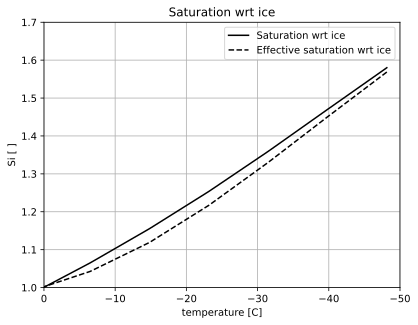

In [11]:
pyplot.plot(K2C(temperature), saturation_wrt_ice, 'k', label="Saturation wrt ice")
pyplot.plot(K2C(temperature), eff_saturation_wrt_ice, 'k--',label="Effective saturation wrt ice")
pyplot.legend()
pyplot.gca().set(
    title="Saturation wrt ice",
    xlabel="temperature [C]",
    ylabel="Si [ ]",
    xlim=(0, -50),
    ylim=(1, 1.7)
)
pyplot.grid()
show_plot('fig_8')

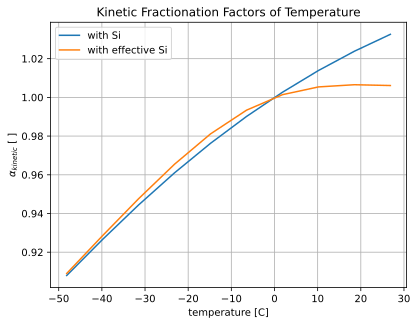

In [12]:
pyplot.plot(K2C(temperature), alpha_kinetic, label="with Si")
pyplot.plot(K2C(temperature), eff_alpha_kinetic, label="with effective Si")
pyplot.legend()
pyplot.gca().set(
    title="Kinetic Fractionation Factors of Temperature",
    xlabel="temperature [C]",
    ylabel="$\\alpha_{{kinetic}}$ [ ]",
)
pyplot.grid()
show_plot('alpha_kinetic_of_temperature')

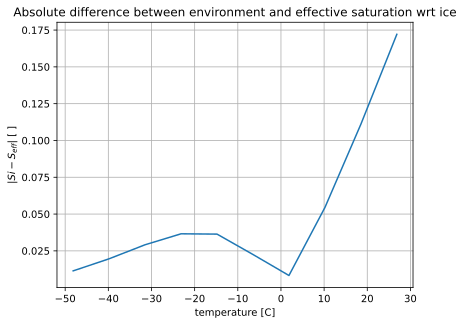

In [13]:
saturation_difference = saturation_wrt_ice - eff_saturation_wrt_ice
pyplot.plot(K2C(temperature), abs(saturation_difference))
pyplot.grid()
pyplot.gca().set(
    title="Absolute difference between environment and effective saturation wrt ice",
    xlabel="temperature [C]",
    ylabel="$|Si - S_{{eff}}|$ [ ]",
)
show_plot("Si_minus_effective_Si")